# Predicting the Review Helpfulness

## Prediction using Traditional ML

### Importing all the necessary libraries 

In [60]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import keras
import string
import nltk
import pydotplus
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.layers import Embedding
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.utils import plot_model
from IPython.display import SVG
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Reading the dataset from the zip file
df = pd.read_json('./data/sample_dataset.json', lines=True)
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0345329139,"[1, 1]",5,This book is definitely a &quot;must read.&quo...,"10 3, 2001",A2UNA438B0FRA8,J. Belfield,HILARIOUS!!!,1002067200
1,1419705644,"[0, 0]",5,This is a really cool book for any adventure t...,"03 20, 2014",A3ZV5ORJ94H2W,"Cherish Woodring ""Cherry""",awesome!,1395273600
2,0062257242,"[7, 8]",4,I originally got this book because I wanted to...,"04 1, 2014",A1UWPSFAJKKAW0,Mrs. Baumann,"A fast-paced horror novel, but too scary for m...",1396310400
3,0778316084,"[0, 0]",3,This was my second least favorite of the Sulli...,"04 3, 2013",AQRTK4Q9CCOVE,Renee M,Ok read,1364947200
4,B00HTCC26C,"[0, 0]",3,"I choose this book because I like the show, bu...","05 15, 2014",A2TCOVTJG32S6L,melonie,Short but pretty good,1400112000


In [4]:
# Summary of the Dataset
for index, column in enumerate(df.columns):
    print('Column-{} - {}'.format(index, column))
print('Shape - {}'.format(df.shape))


Column-0 - asin
Column-1 - helpful
Column-2 - overall
Column-3 - reviewText
Column-4 - reviewTime
Column-5 - reviewerID
Column-6 - reviewerName
Column-7 - summary
Column-8 - unixReviewTime
Shape - (50000, 9)


In [5]:
# Calculating the helpfulness Ratio
def find_helpful_ratio(helpful_list):
    if helpful_list[1] > 0:
        return 1 if helpful_list[0]/helpful_list[1] >=0.5 else 0
    else:
        return 0

In [6]:
df['helpfulness_raatio'] = df['helpful'].apply(func=find_helpful_ratio)
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpfulness_raatio
0,0345329139,"[1, 1]",5,This book is definitely a &quot;must read.&quo...,"10 3, 2001",A2UNA438B0FRA8,J. Belfield,HILARIOUS!!!,1002067200,1
1,1419705644,"[0, 0]",5,This is a really cool book for any adventure t...,"03 20, 2014",A3ZV5ORJ94H2W,"Cherish Woodring ""Cherry""",awesome!,1395273600,0
2,0062257242,"[7, 8]",4,I originally got this book because I wanted to...,"04 1, 2014",A1UWPSFAJKKAW0,Mrs. Baumann,"A fast-paced horror novel, but too scary for m...",1396310400,1
3,0778316084,"[0, 0]",3,This was my second least favorite of the Sulli...,"04 3, 2013",AQRTK4Q9CCOVE,Renee M,Ok read,1364947200,0
4,B00HTCC26C,"[0, 0]",3,"I choose this book because I like the show, bu...","05 15, 2014",A2TCOVTJG32S6L,melonie,Short but pretty good,1400112000,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe77f98668>]],
      dtype=object)

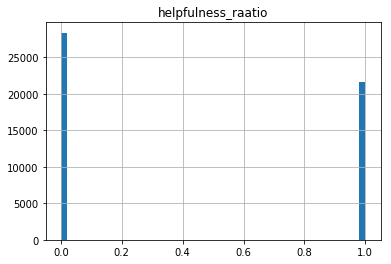

In [7]:
# Plotting the distribution of the helpful ratio
df.hist(column='helpfulness_raatio', bins=50)

In [8]:
# Splitting the dataset into train and test
reviews = df['reviewText']
labels =  df['helpfulness_raatio']
print(len(labels))
X_train, X_test, Y_train, Y_test = train_test_split(reviews, labels, test_size=0.25, random_state=1)
print(len(X_train), len(Y_train))

50000
37500 37500


In [9]:
# Defining the pipeline

def define_models():
    model_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf-svm', SGDClassifier()),])
    parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf-svm__alpha': (1e-2, 1e-3)}
    return [(model_svm, parameters_svm)]

In [10]:
def tune_model(model, X, Y, metric='accuracy', cv=5):
    clf = GridSearchCV(estimator=model[0],param_grid=model[1], cv=cv, scoring=metric)
    clf.fit(X, Y)
    best_score = clf.best_score_
    best_model = clf
    return (best_model, best_score)

In [11]:
def get_best_models_and_parameters():
    final_models = []
    models = define_models()
    for i in range(0,len(models)):
        best_model_and_score = tune_model(models[i], X_train, Y_train)
    final_models.append(best_model_and_score)
    final_list=sorted(final_models, key=lambda score: score[1], reverse=True)
    return final_list


In [12]:
models_list = get_best_models_and_parameters()
model = models_list[0][0]
preds = model.predict(X_test)


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


[[5352 1768]
 [2544 2836]]


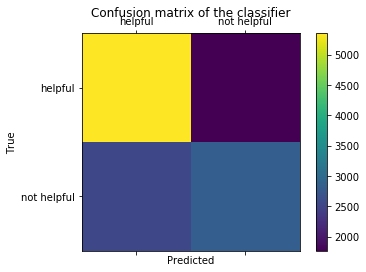

In [13]:
report = confusion_matrix(Y_test, preds)
labels = ['helpful', 'not helpful']
print(report)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(report)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [15]:
print('Accuracy: {}'.format(accuracy_score(Y_test, preds)))
cls_report = classification_report(Y_test, preds)
print('Classification report')
print(cls_report)

Accuracy: 0.65504
Classification report
              precision    recall  f1-score   support

           0       0.68      0.75      0.71      7120
           1       0.62      0.53      0.57      5380

   micro avg       0.66      0.66      0.66     12500
   macro avg       0.65      0.64      0.64     12500
weighted avg       0.65      0.66      0.65     12500



## Prediction using Deep Learning

In [16]:
def read_glove_vectors(glove_file_name):
    with open(glove_file_name, 'r') as f:
        words = set()
        word_to_vector_map = {}
        for line in f:
            line = line.strip().split()
            current_word = line[0]
            words.add(current_word)
            word_to_vector_map[current_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for word in sorted(words):
            words_to_index[word] = i
            index_to_words[i] = word
            i = i + 1
    return words_to_index, index_to_words, word_to_vector_map

In [17]:
#Reading word embeding
 words_to_index, index_to_words, word_to_vector_map = read_glove_vectors('./word_embeding/glove.6B/glove.6B.100d.txt')

In [18]:
def cosine_similarity(u, v):
    """
    Cosine similarity reflects the degree of similariy between u and v
        
    """
    distance = 0.0
    dot = np.dot(u, v)
    l2_norm_u = np.sqrt(np.sum(u**2))
    l2_norm_v = np.sqrt(np.sum(v**2))
    cosine_similarity = dot/(l2_norm_u * l2_norm_v)
    return cosine_similarity

In [38]:
#Sample word analogy using glove word embeding
father = word_to_vector_map.get('father')
mother = word_to_vector_map.get('mother')
son = word_to_vector_map.get('husband')
max_cosine_similarity = -1000
best_word = None
for word in word_to_vector_map.keys():
    if word in (father, mother, son):
        continue
    cosine_sim = cosine_similarity(np.subtract(mother, father), np.subtract(word_to_vector_map.get(word), son))
    if cosine_sim > max_cosine_similarity:
        max_cosine_similarity = cosine_sim
        best_word = word
print(best_word)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


pregnant


In [19]:
#Converting sentence to Indices
def convert_sentence_to_indices(X, words_to_index, max_len):
    """
    Convert the raw sentece into the its indices
    """
    X = X.reset_index(drop=True)
    m = X.shape[0]
    indices = np.zeros((m, max_len))
    table = str.maketrans('', '', string.punctuation)
    stop_words = set(stopwords.words('english'))
    for i in range(m):
        tokens = X[i].lower().split()
        stripped = [word.translate(table) for word in tokens]
        words = [word for word in stripped if word.lower not in stop_words and word.isalpha()]
        j = 0
        for w in words:
            vector = words_to_index.get(w)
            if vector is not None:
                indices[i,j] = words_to_index.get(w)
                j = j + 1
            if j >= max_len:
                break
    return indices

In [20]:
#Create Embeding matrix
def trained_embedding_layer():
    vocab_len = len(words_to_index) + 1
    emb_dim = word_to_vector_map.get('king').shape[0]
    embeding_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, index in words_to_index.items():
        embeding_matrix[index, :] = word_to_vector_map.get(word)
    layer = Embedding(vocab_len, emb_dim, trainable=False)
    layer.build((None,))
    layer.set_weights([embeding_matrix])
    return layer

In [21]:
def get_words_to_index():
    tokonizer = Tokenizer(num_words=10000)
    total_reviews = reviews.values
    tokonizer.fit_on_texts(total_reviews)
    encoded_docs = tokonizer.texts_to_sequences(total_reviews)
    max_length = max([len(s.split()) for s in total_reviews])
    vocab_size = len(tokonizer.word_index) + 1
    padded_sequences = pad_sequences(encoded_docs, maxlen=max_length)
    word_index = tokonizer.word_index
    return vocab_size, word_index,padded_sequences, max_length

In [69]:
# Build Helpfulness prediction model
def helpfulness_model(input_shape):
    # Define sentence indices as the input of the graph.
    sentence_indices = Input(input_shape, dtype='int32')
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = trained_embedding_layer()
    
    # Propagate sentence_indices through your embedding layer.
    embeddings = embedding_layer(sentence_indices)
    
    # Propogate the embedings via LSTM cell of 64 units
    X = LSTM(32, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(rate=0.5)(X)
    # Propogate vis 64 units LSTM layer
    X = LSTM(32, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(rate=0.5)(X)
    # Dense layer with 1 units
    X = Dense(1, activation='sigmoid')(X)
    X = Activation('sigmoid')(X)
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
   
    return model

In [70]:
#Compile the model
#vocab_size, word_index, padded_sequences, max_length = get_words_to_index()
model = helpfulness_model((50,))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50, 100)           40000100  
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 32)            17024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 32)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
__________

In [71]:
checkpointer = ModelCheckpoint(filepath='model/helpfulness_prediction_model.hdf5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [72]:
#compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [73]:
#X_train, X_test, Y_train, Y_test = train_test_split(padded_sequences, labels, test_size=0.25, random_state=1)
X_train_indices = convert_sentence_to_indices(X_train, words_to_index, 50)

In [74]:
#Fit the model
model.fit(X_train_indices, Y_train, epochs = 50, batch_size = 32, validation_split=0.2, callbacks=[checkpointer, early_stopping], shuffle=True)

Train on 30000 samples, validate on 7500 samples
Epoch 1/50
30000/30000 [==============================] - 46s 2ms/step - loss: 0.6949 - acc: 0.4316 - val_loss: 0.6932 - val_acc: 0.4387

Epoch 00001: val_acc improved from -inf to 0.43867, saving model to model/helpfulness_prediction_model.hdf5
Epoch 2/50
30000/30000 [==============================] - 39s 1ms/step - loss: 0.6932 - acc: 0.4317 - val_loss: 0.6932 - val_acc: 0.4387

Epoch 00002: val_acc did not improve from 0.43867
Epoch 3/50
30000/30000 [==============================] - 54s 2ms/step - loss: 0.6932 - acc: 0.4319 - val_loss: 0.6931 - val_acc: 0.4387

Epoch 00003: val_acc did not improve from 0.43867
Epoch 4/50
30000/30000 [==============================] - 55s 2ms/step - loss: 0.6932 - acc: 0.4336 - val_loss: 0.6931 - val_acc: 0.4387

Epoch 00004: val_acc did not improve from 0.43867
Epoch 5/50
30000/30000 [==============================] - 48s 2ms/step - loss: 0.6932 - acc: 0.4360 - val_loss: 0.6931 - val_acc: 0.4387

Epo

In [75]:
X_test_indices = convert_sentence_to_indices(X_test, words_to_index, 50)
pred = model.predict(X_test_indices)
print('Accuracy: {}'.format(model.evaluate(X_test_indices, Y_test)))


12500/12500 [==============================] - 4s 286us/step
Accuracy: [0.689021662197113, 0.4304]


Compiling the created model with loss function, optimizer and evaluation metrics. 
For this task we are using `binary_crossentropy` as loss function and `adam` as optimizer and `accuracy` as a evaluation metric 

Plotting model and the history of the model

In [63]:
#plot_model(model, to_file='model.png')

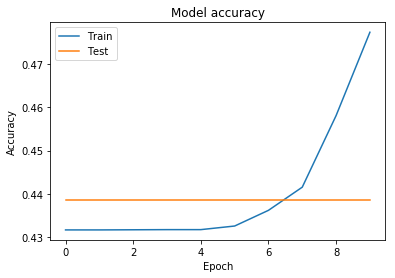

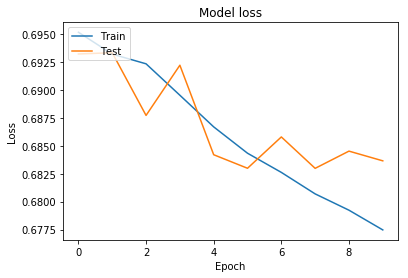

In [66]:
# Plot training & validation accuracy values
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()